# LSTM
Cell Line A549. LSTM 134. Coding 2-3K. 

Acc 71%, Prec 69%, Recall 68%, F1 68%.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-01-17 17:40:54.213248
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=2000
MAXLEN=3000   

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
CELL_LINE = 0
print('Use only this cell line',all_cell_lines[CELL_LINE])

Use only this cell line A549


## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        overall_count = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_str = fields[cell_line+1]
                    if rci_str != "nan":
                        # Convert string nan to float(nan)
                        rci_val = float(rci_str)
                        gene_to_rci[gene_id] = rci_val
                        overall_sum += rci_val
                        overall_count += 1
        overall_mean = overall_sum / overall_count
        print('Number of RCI values',overall_count)
        print('Mean RCI value',overall_mean)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [7]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Num labels:',len(labels))
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num sequences:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2023-01-17 17:41:22.369185
Load RCI values...
Number of RCI values 13000
Mean RCI value -0.036765961332307674
Num RCI: 13000
Example RCI: [('ENSG00000000003', 1.85734), ('ENSG00000000005', 5.88264), ('ENSG00000000419', 2.58954)]
Load genes...
2023-01-17 17:41:23.282322
Load sequence...
2023-01-17 17:41:36.390419
Num IDs: 11162
Example IDs: [('ENSG00000078808', 'ENST00000263741.12'), ('ENSG00000224051', 'ENST00000343938.9'), ('ENSG00000197530', 'ENST00000378712.5'), ('ENSG00000008128', 'ENST00000356200.7')]
Count 5073 ones out of 11162 labels.
Num labels: 11162
Example labels: [0, 1, 0, 0]
Num sequences: 11162
Example sequence: [160, 126, 247, 219, 107, 172, 176, 191, 251, 236, 175, 188, 238, 181, 212, 79, 59, 234, 165, 147, 74, 40, 159, 122, 231, 155, 107, 171, 169, 163, 138, 38, 151, 90, 101, 145, 67, 9, 35, 139, 42, 167, 154, 102, 152, 95, 123, 234, 167, 155, 105, 163, 138, 40, 159, 121, 226, 135, 27, 108, 175, 187, 233, 162, 135, 25, 99, 140, 48, 190, 246, 216, 93, 115, 202, 40, 160

## Model

In [8]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=False)   
    rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=True) )
    dens_layer = TimeDistributed(Dense(DCELLS))
    flat_layer = Flatten()
    drop_layer = Dropout(0.5) # this model will rely on specific time points not patterns
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    #rnn.add(mask_layer)
    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    rnn.add(dens_layer)
    rnn.add(flat_layer)
    rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [9]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2023-01-17 17:41:36.430270
COMPILE
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2997, 4)           1028      
                                                                 
 bidirectional (Bidirectiona  (None, 2997, 64)         9472      
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 2997, 16)         1040      
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 47952)             0         
                                                                 
 dropout (Dropout)           (None, 47952)             0         
                                                                 
 dense_1 (Dense)     

## Training

In [10]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = threshold
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2023-01-17 17:41:39.590684
2023-01-17 17:41:39.591263
splitting
Fold 1
Training example
[147  73  35 ...   0   0   0]
Train sizes (8855, 2997) (8855, 1)
Valid sizes (2307, 2997) (2307, 1)
Train set ones/size 4006 / 8855
Valid set ones/size 1067 / 2307
BUILD MODEL
COMPILE
FIT
2023-01-17 17:41:42.010900
Epoch 1/3
277/277 [==============================] - 54s 168ms/step - loss: 0.5832 - accuracy: 0.7004 - val_loss: 0.5337 - val_accuracy: 0.7378
Epoch 2/3
277/277 [==============================] - 46s 164ms/step - loss: 0.5465 - accuracy: 0.7343 - val_loss: 0.5310 - val_accuracy: 0.7529
Epoch 3/3
277/277 [==============================] - 44s 160ms/step - loss: 0.5232 - accuracy: 0.7473 - val_loss: 0.5346 - val_accuracy: 0.7261


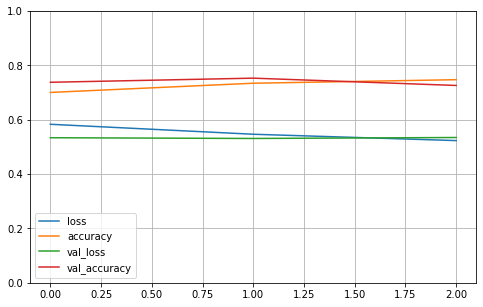

Compute valiation accuracy
2023-01-17 17:44:06.846473
Range of scores: 0.0129486965 to 0.96999234
Predicted zeros and ones 1388 919
Accuracy: 72.61% Precision: 73.67% Recall: 63.45% F1: 68.18%
2023-01-17 17:44:12.656870
Fold 2
Training example
[147  73  35 ...   0   0   0]
Train sizes (8942, 2997) (8942, 1)
Valid sizes (2220, 2997) (2220, 1)
Train set ones/size 4116 / 8942
Valid set ones/size 957 / 2220
BUILD MODEL
COMPILE
FIT
2023-01-17 17:44:15.046141
Epoch 1/3
280/280 [==============================] - 48s 161ms/step - loss: 0.5788 - accuracy: 0.6941 - val_loss: 0.5466 - val_accuracy: 0.7477
Epoch 2/3
280/280 [==============================] - 44s 158ms/step - loss: 0.5337 - accuracy: 0.7446 - val_loss: 0.5666 - val_accuracy: 0.7279
Epoch 3/3
280/280 [==============================] - 45s 159ms/step - loss: 0.4930 - accuracy: 0.7610 - val_loss: 0.5837 - val_accuracy: 0.7306


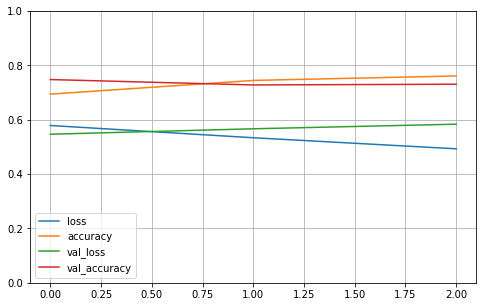

Compute valiation accuracy
2023-01-17 17:46:32.245655
Range of scores: 0.009830451 to 0.9901545
Predicted zeros and ones 1237 983
Accuracy: 73.06% Precision: 68.26% Recall: 70.11% F1: 69.18%
2023-01-17 17:46:38.495042
Fold 3
Training example
[147  73  35 ...   0   0   0]
Train sizes (8841, 2997) (8841, 1)
Valid sizes (2321, 2997) (2321, 1)
Train set ones/size 4031 / 8841
Valid set ones/size 1042 / 2321
BUILD MODEL
COMPILE
FIT
2023-01-17 17:46:40.836779
Epoch 1/3
277/277 [==============================] - 49s 167ms/step - loss: 0.5819 - accuracy: 0.6966 - val_loss: 0.5656 - val_accuracy: 0.7303
Epoch 2/3
277/277 [==============================] - 45s 161ms/step - loss: 0.5325 - accuracy: 0.7402 - val_loss: 0.5683 - val_accuracy: 0.7225
Epoch 3/3
277/277 [==============================] - 44s 160ms/step - loss: 0.4972 - accuracy: 0.7662 - val_loss: 0.5873 - val_accuracy: 0.7027


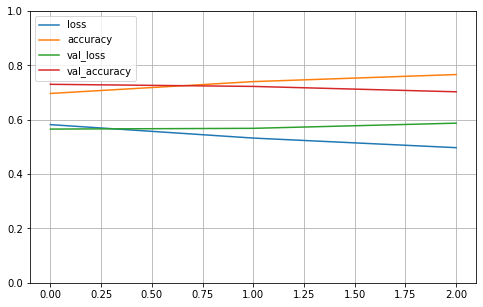

Compute valiation accuracy
2023-01-17 17:48:59.220517
Range of scores: 0.016285496 to 0.9760356
Predicted zeros and ones 1293 1028
Accuracy: 70.27% Precision: 67.12% Recall: 66.22% F1: 66.67%
2023-01-17 17:49:05.010611
Fold 4
Training example
[147  73  35 ...   0   0   0]
Train sizes (8999, 2997) (8999, 1)
Valid sizes (2163, 2997) (2163, 1)
Train set ones/size 4108 / 8999
Valid set ones/size 965 / 2163
BUILD MODEL
COMPILE
FIT
2023-01-17 17:49:07.345646
Epoch 1/3
282/282 [==============================] - 49s 162ms/step - loss: 0.5798 - accuracy: 0.7024 - val_loss: 0.5677 - val_accuracy: 0.7152
Epoch 2/3
282/282 [==============================] - 45s 159ms/step - loss: 0.5384 - accuracy: 0.7417 - val_loss: 0.5574 - val_accuracy: 0.7175
Epoch 3/3
282/282 [==============================] - 46s 162ms/step - loss: 0.5216 - accuracy: 0.7508 - val_loss: 0.5853 - val_accuracy: 0.7087


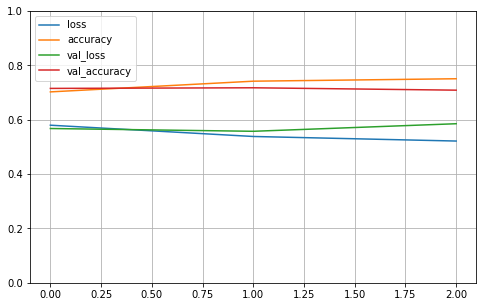

Compute valiation accuracy
2023-01-17 17:51:27.368506
Range of scores: 0.036771648 to 0.97556555
Predicted zeros and ones 920 1243
Accuracy: 70.87% Precision: 63.48% Recall: 81.76% F1: 71.47%
2023-01-17 17:51:32.337364
Fold 5
Training example
[160 126 247 ...   0   0   0]
Train sizes (9011, 2997) (9011, 1)
Valid sizes (2151, 2997) (2151, 1)
Train set ones/size 4031 / 9011
Valid set ones/size 1042 / 2151
BUILD MODEL
COMPILE
FIT
2023-01-17 17:51:34.654973
Epoch 1/3
282/282 [==============================] - 48s 161ms/step - loss: 0.5813 - accuracy: 0.6957 - val_loss: 0.5652 - val_accuracy: 0.7201
Epoch 2/3
282/282 [==============================] - 45s 159ms/step - loss: 0.5368 - accuracy: 0.7398 - val_loss: 0.5813 - val_accuracy: 0.6978
Epoch 3/3
282/282 [==============================] - 45s 159ms/step - loss: 0.5102 - accuracy: 0.7573 - val_loss: 0.5922 - val_accuracy: 0.7006


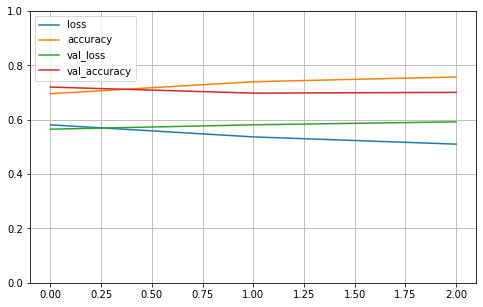

Compute valiation accuracy
2023-01-17 17:53:52.786017
Range of scores: 0.0080056405 to 0.9716583
Predicted zeros and ones 1329 822
Accuracy: 70.06% Precision: 74.21% Recall: 58.54% F1: 65.45%
2023-01-17 17:53:58.587351

Cross validation 5 folds 3 epochs
 accuracy mean 71.37% +/- 1.23
 precision mean 69.35% +/- 4.07
 recall mean 68.02% +/- 7.84
 F1 mean 68.19% +/- 2.08
2023-01-17 17:53:58.589386


In [11]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())